In [1]:
from __future__ import print_function
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import ROOT
# %jsroot on
from ROOT import gROOT, gStyle, gDirectory, gPad

from array import array

import constants
import crv_event
import crv_spill
import utils
import geometry
import geometry_constants
import filepath
import portROOT2pd

gROOT.Reset()
gROOT.SetBatch(1)
gROOT.ProcessLine( "gErrorIgnoreLevel = 1001;")
gStyle.SetOptStat(111110)
gStyle.SetOptFit(0)
gStyle.SetLineScalePS(0.3)

topdir = os.path.dirname(os.path.abspath("__file__"))
analysis_dir = os.path.join(topdir,"analysis_root_files")

fileList = filepath.getfilelist(["SiDet2CMBScan"],"recoROOT",6)[0]
additional_dict = {'VoverN'    :filepath.datatag["SiDet2CMBScan"]["VoverN"],
                   'VppN'      :filepath.datatag["SiDet2CMBScan"]["VppN"],
                   'tempSetup' :filepath.datatag["SiDet2CMBScan"]["tempSetup"],
                   'tempSensor':filepath.datatag["SiDet2CMBScan"]["tempSensor"]}

nSmooth = 1 

plotdict = {'*':[["temperatureCMB[0][0]","temperatureCMB[0][8]"], 
                 ["temperatureFEB[0]"],
                 ["busSiPMBias[0][0:4]"], 
                 ["busSiPMBias[0][4:8]"]]}

Welcome to JupyROOT 6.28/10


Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001827_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001828_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001829_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001830_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001831_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001832_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001833_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001834_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001835_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001836_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001837_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.001838_000.root
Reading file: rec.mu2e.CRV_wideband_cosmics.CRVWB-000-006-000.00

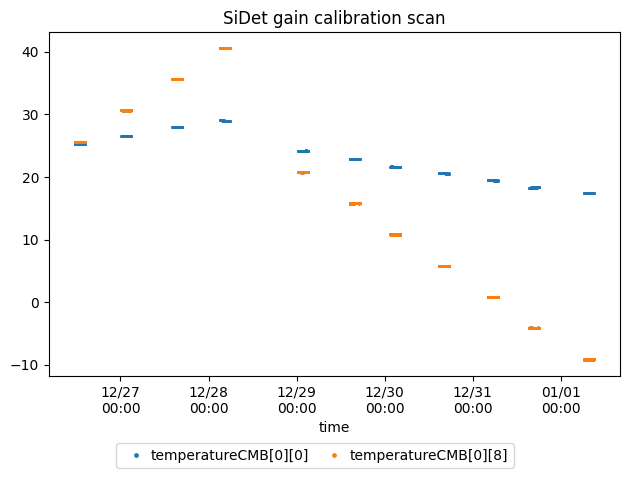

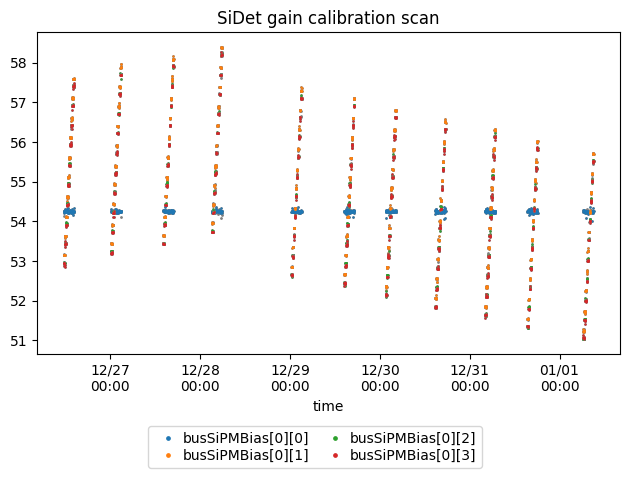

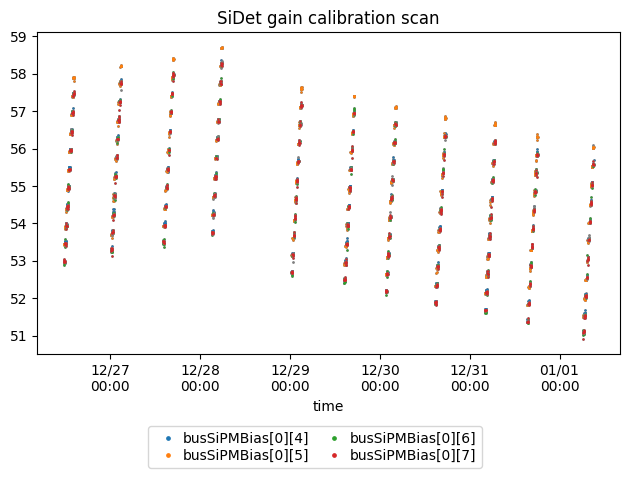

In [2]:
# tfig = utils.plot_dqm(fileList, plotdict, '== 0x0', False, nSmooth, True, "SiDet CMB temperature scan;time;") 
tfig = utils.plot_dqm(fileList, plotdict, '& 0xfffffffffffffe == 0x0', False, nSmooth, True, "SiDet gain calibration scan;time;") 

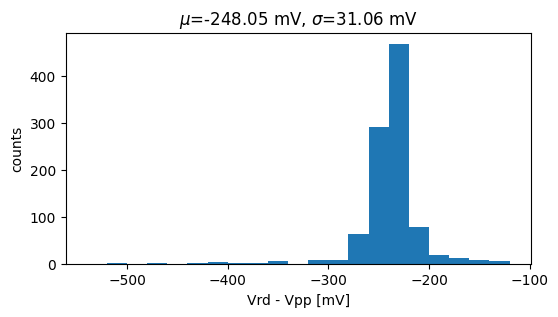

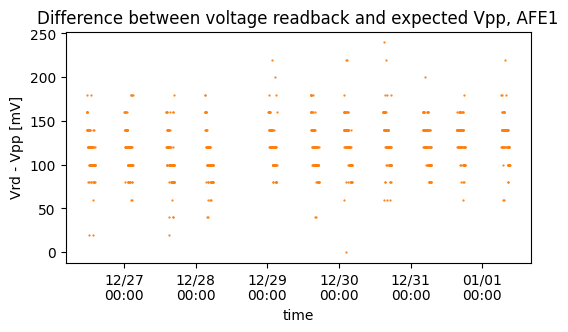

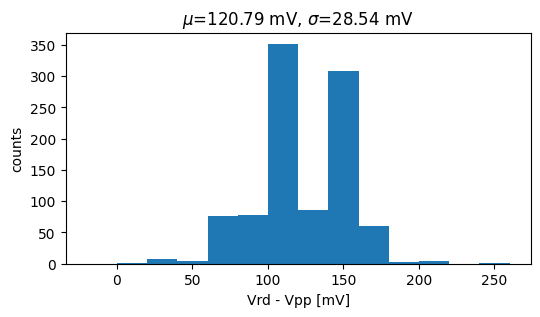

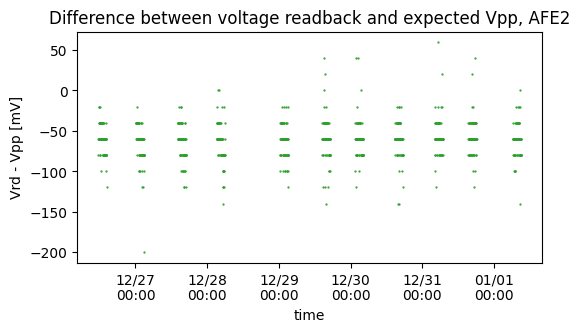

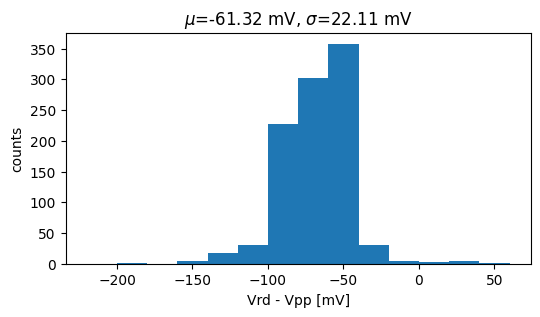

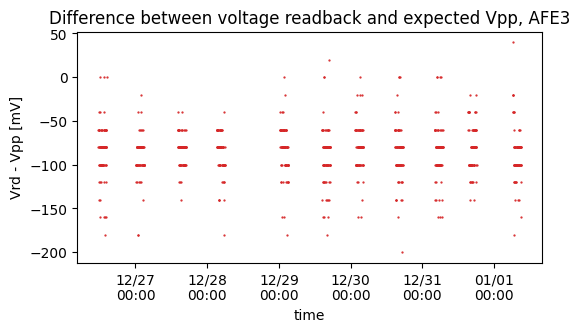

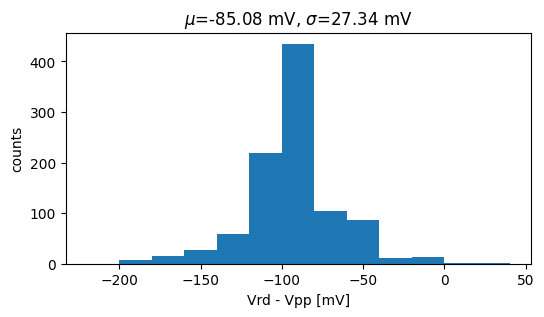

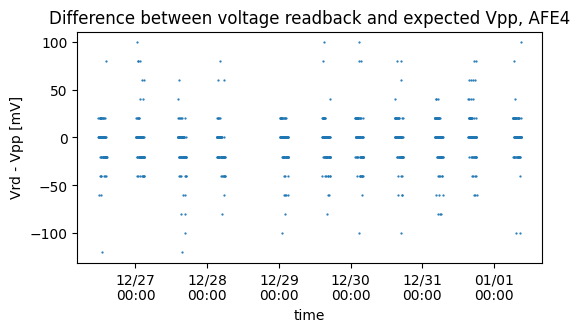

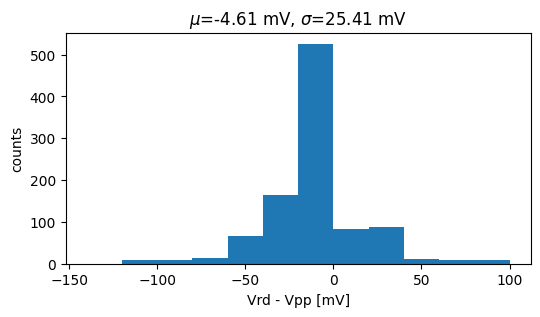

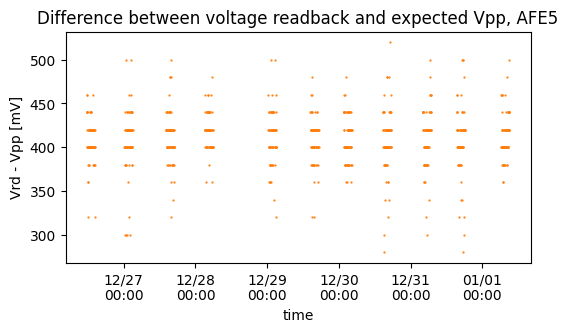

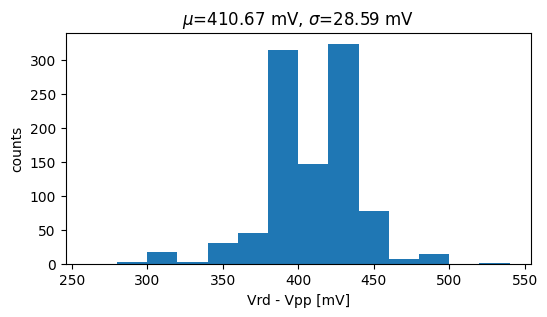

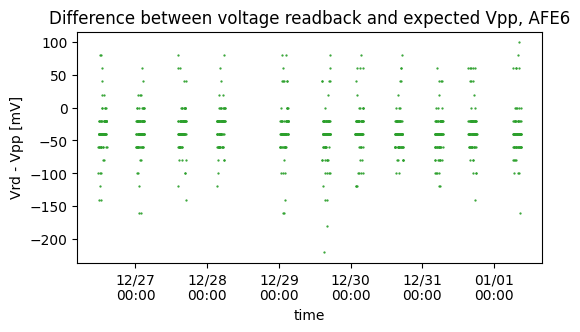

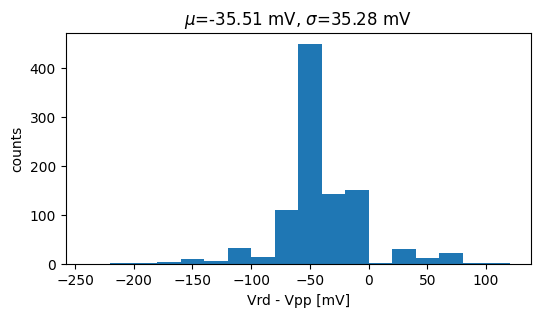

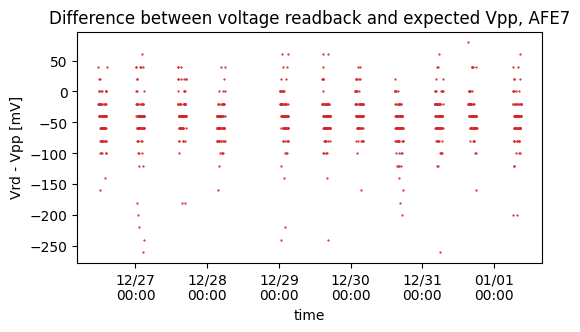

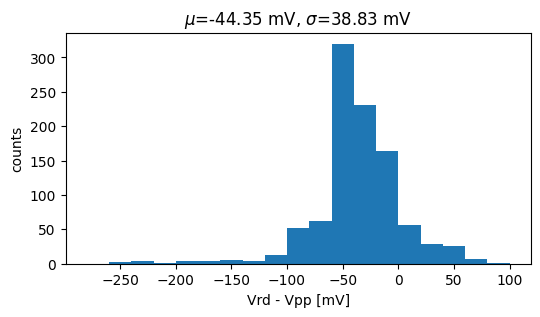

In [3]:
# assemble norminal Vpp array
VppN_perspill = []
for i, filename in enumerate(fileList):
    fFile = ROOT.TFile(filename, "READ")
    spilltree = fFile.Get("spills")
    nSpill = spilltree.GetEntries()
    VppN_perspill += [filepath.datatag["SiDet2CMBScan"]["VppN"][i]]*nSpill
    fFile.Close()
VppN_perspill = np.array(VppN_perspill)
VppN_list = [(np.array([54.5]*VppN_perspill.size) if i == 0 else VppN_perspill) for i in range(8)]

for iAFE in range(8):
    tline = tfig[2+int(iAFE/4)].gca().get_lines()[(iAFE%4)*2]
    xdata = tline.get_xdata()
    xdata = np.array([xdata[i].timestamp() for i in range(xdata.size)])
    ydata = tline.get_ydata()
    # print(ydata)
    plot_data = 1000.*(ydata-VppN_list[iAFE])
    
    plt.figure(figsize = (6,3))
    utils.plot_ts(xdata, plot_data, '.', markersize=1.2,  
                       rasterized=True, color=constants.colors[iAFE%4%10])
    ax = plt.gca()
    ax.set_title("Difference between voltage readback and expected Vpp, AFE%i"%iAFE)
    ax.set_xlabel("time")
    ax.set_ylabel("Vrd - Vpp [mV]")
    plt.show()

    plt.figure(figsize = (6,3))
    rangemin = np.min(plot_data)-20
    rangemax = np.max(plot_data)+20
    step = 20
    nbins = int((rangemax-rangemin)/step)
    plt.hist(plot_data, [float(rangemin)+step*float(i) for i in range(nbins+1)])
    plt.title(r'$\mu$'+"=%.2f mV"%(np.mean(plot_data))+r', $\sigma$'+"=%.2f mV"%(np.std(plot_data)))
    plt.xlabel("Vrd - Vpp [mV]")
    plt.ylabel("counts")
    plt.show()


In [4]:
import pandas as pd
import pickle
from scipy import stats

df = portROOT2pd.PortToDF(fileList, additional_dict)
pklname = os.path.join(analysis_dir,"tempScanSiDetRun2.pkl")

with open(pklname, 'wb') as f:
    pickle.dump(df, f)

In [1]:
from __future__ import print_function
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import pandas as pd
import pickle
from scipy.optimize import curve_fit
from scipy import stats

topdir = os.path.dirname(os.path.abspath("__file__"))
analysis_dir = os.path.join(topdir,"analysis_root_files")
pklname = os.path.join(analysis_dir,"tempScanSiDetRun2.pkl")

with open(pklname, 'rb') as f:
    df = pickle.load(f)

# remove runs with Vover < 2.5V 
df = df.query("VoverN > 2.0").reset_index() 

display(df)
#with pd.option_context('display.max_rows', None,
#                       'display.max_columns', None,
#                       'display.precision', 3,
#                       ):
#    print(df)


index   run  subrun  FEB  ch   pedestal    calibRaw    calibAdj  \
0       128  1829       0    0   0 -11.235000  376.625000  419.561005   
1       129  1829       0    0   1  17.024099  389.502991  432.148987   
2       130  1829       0    0   2   1.543210  395.863007  438.161011   
3       131  1829       0    0   3  -1.407410  387.260986  430.408997   
4       132  1829       0    0   4 -11.849700  376.958008  421.735992   
...     ...   ...     ...  ...  ..        ...         ...         ...   
5627   7035  1936       0    0  59  -7.443500  760.973999  564.221985   
5628   7036  1936       0    0  60  -8.314870  750.843994  554.072998   
5629   7037  1936       0    0  61  -4.553300  777.971008  582.442017   
5630   7038  1936       0    0  62   2.200310  757.937988  563.072021   
5631   7039  1936       0    0  63   8.213310  745.763977  549.612000   

        FEBtemp   CMBtemp      biasV        PEs  PEsCorrected  VoverN  VppN  \
0     47.433334  25.06250  54.253338  54.887486     58.100155     2.5  54.0   
1     47.433334  25.06250  54.253338  63.445820     67.243401     2.5  54.0   
2     47.433334  25.06250  54.253338  65.715958     69.694725     2.5  54.0   
3     47.433334  25.06250  54.253338  54.678356     57.855827     2.5  54.0   
4     47.433334  25.40625  54.253338  63.387493     67.524750     2.5  54.0   
...         ...       ...        ...        ...           ...     ...   ...   
5627   46.90444  -9.03125  55.582218  68.456444     49.891953     6.0  55.6   
5628   46.90444  -9.12500  55.582218  75.549629     54.971813     6.0  55.6   
5629   46.90444  -9.12500  55.582218  67.935204     49.337528     6.0  55.6   
5630   46.90444  -9.12500  55.582218  61.119427     44.343967     6.0  55.6   
5631   46.90444  -9.12500  55.582218  52.105450     37.866062     6.0  55.6   

      tempSetup  tempSensor  
0          25.0        25.0  
1          25.0        25.0  
2          25.0        25.0  
3          25.0        25.0  
4          25.0        25.0  
...         ...         ...  
5627      -10.0        -9.4  
5628      -10.0        -9.4  
5629      -10.0        -9.4  
5630      -10.0        -9.4  
5631      -10.0        -9.4  

[5632 rows x 17 columns]

level_0  index   run  subrun  FEB  ch   pedestal  calibRaw  calibAdj  \
0         10    138  1829       0    0  10   0.667823       0.0       0.0   
1         19    147  1829       0    0  19  -6.553070       0.0       0.0   
2         37    165  1829       0    0  37 -26.941700       0.0       0.0   
3         71    199  1830       0    0   7 -14.060900       0.0       0.0   
4         74    202  1830       0    0  10   0.568438       0.0       0.0   
..       ...    ...   ...     ...  ...  ..        ...       ...       ...   
117     4051   5075  1906       0    0  19  -6.384140       0.0       0.0   
118     5130   6538  1929       0    0  10   0.689131       0.0       0.0   
119     5194   6602  1930       0    0  10   0.675537       0.0       0.0   
120     5258   6666  1931       0    0  10   0.606366       0.0       0.0   
121     5322   6730  1932       0    0  10   0.616895       0.0       0.0   

       FEBtemp    CMBtemp      biasV  PEs  PEsCorrected  VoverN  VppN  \
0    47.433334  25.406250  54.117779  0.0           0.0     2.5  54.0   
1    47.433334  25.500000  53.953335  0.0           0.0     2.5  54.0   
2    47.433334  25.390625  53.980003  0.0           0.0     2.5  54.0   
3        47.29  25.393749  54.259998  0.0           0.0     3.0  54.5   
4        47.29  25.393749  54.610004  0.0           0.0     3.0  54.5   
..         ...        ...        ...  ...           ...     ...   ...   
117      47.25   5.875000  56.322502  0.0           0.0     6.0  56.4   
118  47.045555  -9.062500  52.246670  0.0           0.0     2.5  52.1   
119   47.06143  -9.087500  52.725712  0.0           0.0     3.0  52.6   
120   47.09222  -9.085938  53.246662  0.0           0.0     3.5  53.1   
121  47.015713  -9.109375  53.739998  0.0           0.0     4.0  53.6   

     tempSetup  tempSensor  
0         25.0        25.0  
1         25.0        25.0  
2         25.0        25.0  
3         25.0        25.0  
4         25.0        25.0  
..         ...         ...  
117        5.0         5.3  
118      -10.0        -9.4  
119      -10.0        -9.4  
120      -10.0        -9.4  
121      -10.0        -9.4  

[122 rows x 18 columns]

[ 7 10 18 19 37]


Text(0, 0.5, 'counts')

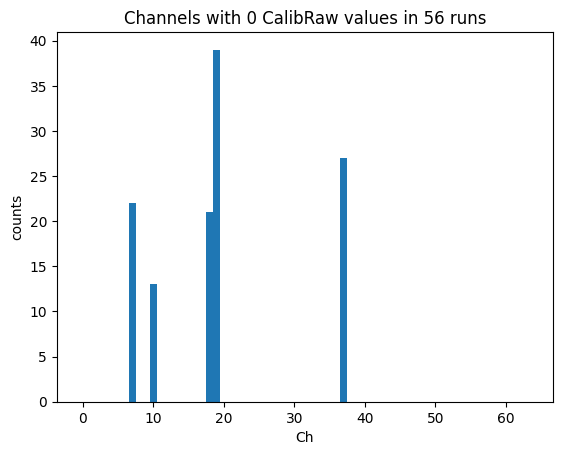

In [2]:
df1 = df.query("calibRaw == 0.0").reset_index()
display(df1)

badChannels = df1['ch'].unique()
badChannels = np.sort(badChannels)
print(badChannels)

plt.figure()
plt.hist(df1['ch'], [i-0.5 for i in range(64+1)])
plt.title("Channels with 0 CalibRaw values in 56 runs")
plt.xlabel("Ch")
plt.ylabel("counts") 

Too few Vbias: chan 10 at set temp -10 C
Too few Vbias: chan 10 at set temp 5 C
Too few Vbias: chan 10 at set temp 25 C
Too few Vbias: chan 18 at set temp 30 C
Bad channel: 18 at set temp 35 C
Bad channel: 18 at set temp 40 C
Bad channel: 19 at set temp 5 C
Bad channel: 19 at set temp 25 C
Bad channel: 19 at set temp 30 C
Too few Vbias: chan 19 at set temp 35 C
Bad channel: 19 at set temp 40 C
Bad channel: 37 at set temp 25 C
Too few Vbias: chan 37 at set temp 30 C
Bad channel: 37 at set temp 35 C
Bad channel: 37 at set temp 40 C


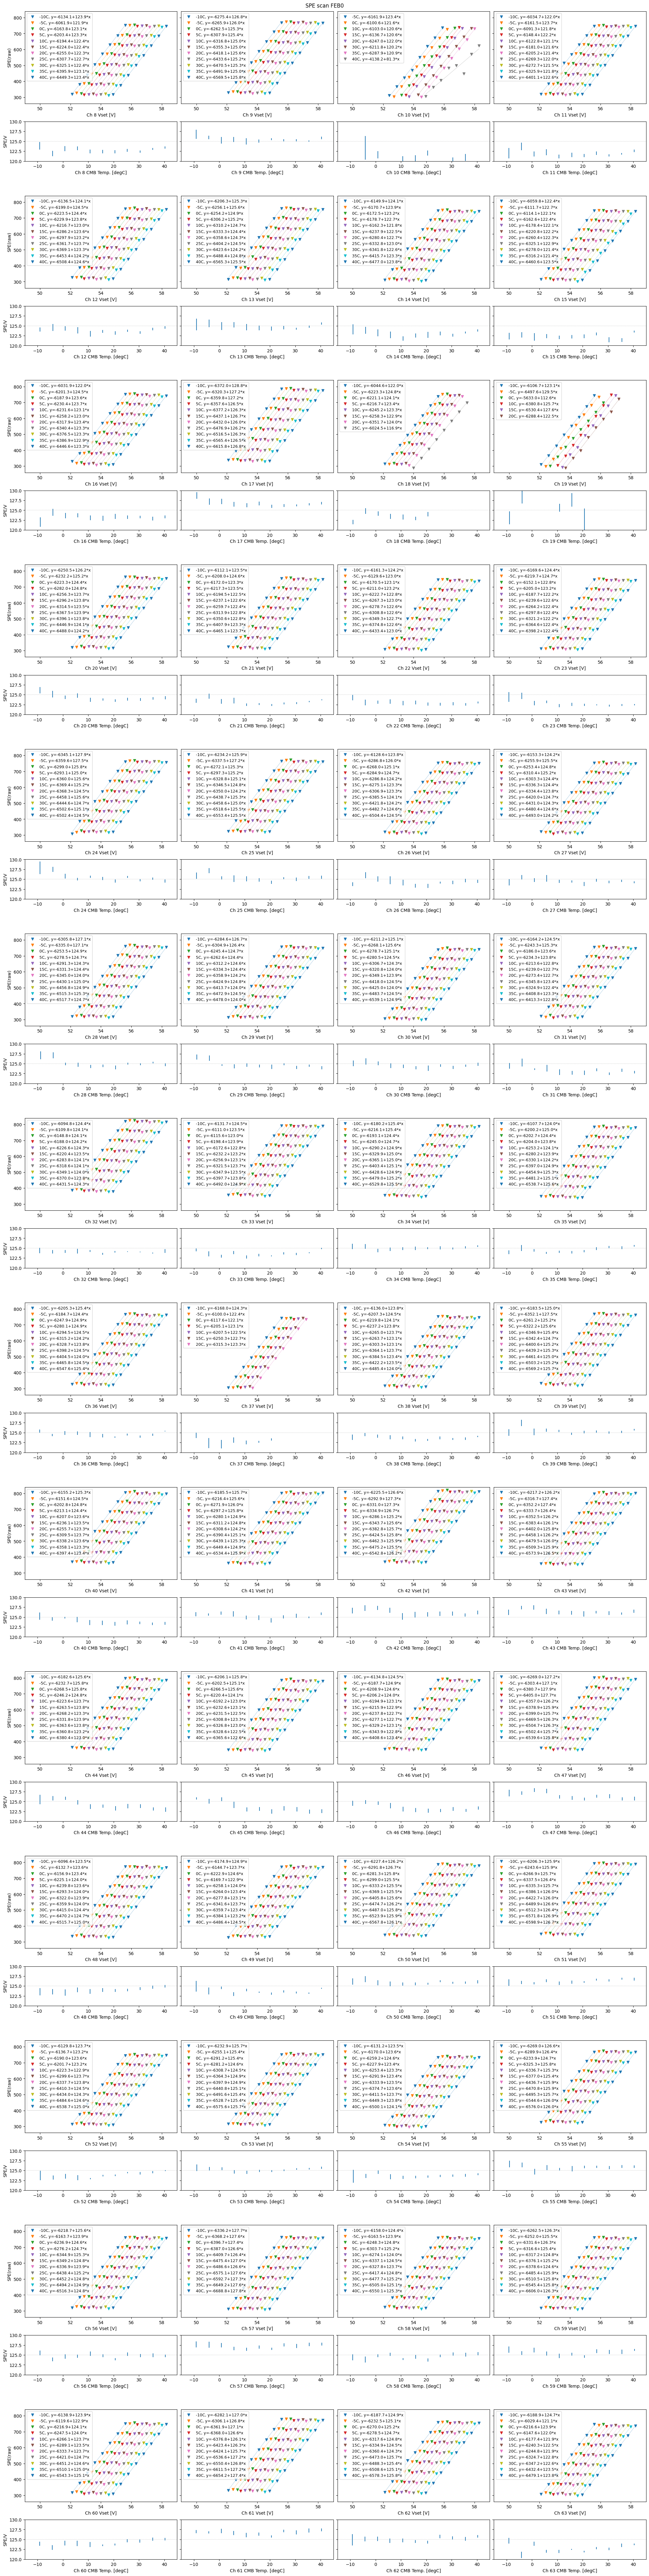

In [3]:
FEBs = df['FEB'].unique()
FEBs = np.sort(FEBs)
tempSetups = df['tempSetup'].unique()
tempSetups = np.sort(tempSetups)

bad_channels = [ 7, 10, 18, 19, 37]

def func_lin(x, k, b):
    return k*x+b
    
def plotter(FEBs, tempSetups, title = '', nr = 14, nc = 4): # only channel 8-63
    global bad_channels
    df_SPE = pd.DataFrame(columns=['chan', 'temp_setup', 'tempCMB_mean', 'tempCMB_err',
                                   'SPEperV', 'SPEperV_err', 'intercept', 'intercept_err',
                                   'Vbd', 'Vbd_err', 'spe_3V_over', 
                                   'spe_54V_fix', 'spe_55V_fix'])
    maintitle = title
    for FEB in FEBs:
        fig = plt.figure(layout = 'constrained', figsize = (5*nc+0.5, 5.8*nr+0.5))
        plt.suptitle(maintitle+" FEB%i"%FEB)
        subfigs = fig.subfigures(nr, 1, hspace=0.1)
        for iRow, tSubFig in enumerate(subfigs):
            axs = tSubFig.subplots(2, nc, sharey='row',
                                   gridspec_kw={'width_ratios':[5 for i in range(nc)],
                                                'height_ratios':[3.5,1.5],
                                                'wspace':0, 'hspace':0})
            ytitles = ['SPE(raw)', 'SPE/V']
            xtitles = ['Vset [V]', 'CMB Temp. [degC]']
            for ii in range(2):
                axs[ii, 0].set_ylabel(ytitles[ii])
            for ii in range(nc):
                for jj in range(2):
                    axs[jj, ii].set_xlabel('Ch %i'%((2+iRow)*nc+ii)+' '+xtitles[jj])

            for inHDMI_chan in range(nc):
                chan = (2+iRow)*nc+inHDMI_chan
                #if chan in bad_channels:
                    #print("Skip channel %i"%chan)
                    #continue
                SPEperV_list = []
                SPEperVerr_list = []
                meanTemp_list = []
                stdTemp_list = []

                emptyFlag = True
                for tTempSetup in tempSetups:
                    df_ = df.query("FEB==%i & ch==%i & tempSetup==%i"%(FEB, chan, tTempSetup)).reset_index()
                    xx = df_['VppN'].astype(float)
                    yy = df_['calibRaw'].astype(float)
                    meanTemp = np.mean(df_['CMBtemp'].astype(float))
                    stdTemp = np.std(df_['CMBtemp'].astype(float))
                    mask = (yy>0)
                    xx=xx[mask]
                    yy=yy[mask]
                    if yy.size==0:
                        print("Bad channel: %d at set temp %.0f C"%(chan, tTempSetup))
                        continue

                    if len(xx)>3 and np.max(xx)-np.min(xx)>3:
                        emptyFlag = False
                        popt, pcov = curve_fit(func_lin, xx.astype(float), yy.astype(float))
                        slope = popt[0]
                        intercept = popt[1]
                        std_err = np.sqrt(pcov[0,0])
                        intercept_stderr = np.sqrt(pcov[1,1])
                        meanTemp_list.append(meanTemp)
                        stdTemp_list.append(stdTemp)
                        SPEperV_list.append(slope)
                        SPEperVerr_list.append(std_err)

                        tscatter = axs[0, inHDMI_chan].plot(xx, yy, 'v', label='%.0fC, y=%.1f+%.1f*x'%(tTempSetup, intercept, slope))
                        axs[0, inHDMI_chan].plot(xx, slope * xx + intercept, ':', color = tscatter[0].get_color(), linewidth=0.7)
                        axs[0, inHDMI_chan].set_xlim(49.,59.)
                        axs[0, inHDMI_chan].set_ylim(260.,840.)
                        
                        new_row = {'chan':chan, 
                                   'temp_setup':tTempSetup, 
                                   'tempCMB_mean':meanTemp, 
                                   'tempCMB_err':stdTemp,
                                   'SPEperV':slope, 
                                   'SPEperV_err':std_err, 
                                   'intercept':intercept, 
                                   'intercept_err':intercept_stderr,
                                   'Vbd':-intercept/slope, 
                                   'Vbd_err':(-intercept/slope)*np.sqrt(std_err*std_err/slope/slope+intercept_stderr*intercept_stderr/intercept/intercept),
                                   'spe_3V_over':slope*3, 
                                   'spe_54V_fix':slope*54+intercept, 
                                   'spe_55V_fix':slope*55+intercept}
                        df_SPE.loc[len(df_SPE)] = new_row
                    else:
                        print("Too few Vbias: chan %d at set temp %.0f C"%(chan, tTempSetup))
                if not emptyFlag:
                    axs[0, inHDMI_chan].legend(fontsize=9)

                SPEperV_list = np.array(SPEperV_list)
                SPEperVerr_list = np.array(SPEperVerr_list)
                meanTemp_list = np.array(meanTemp_list)
                stdTemp_list = np.array(stdTemp_list)

                axs[1, inHDMI_chan].errorbar(meanTemp_list, SPEperV_list, xerr=stdTemp_list, yerr=SPEperVerr_list,
                                             linestyle='none')
                axs[1, inHDMI_chan].axhline(y = 125, color = '#929591', linestyle = '--', linewidth=0.3) 
                axs[1, inHDMI_chan].set_xlim(-15.,45.)
                axs[1, inHDMI_chan].set_ylim(120.,130.)
    
    return df_SPE

df_SPE = plotter(FEBs, tempSetups, 'SPE scan')

In [4]:
display(df_SPE)

chan  temp_setup  tempCMB_mean  tempCMB_err     SPEperV  SPEperV_err  \
0       8       -10.0     -9.090346     0.015083  123.861335     0.970954   
1       8        -5.0     -4.084440     0.024124  121.900919     0.691430   
2       8         0.0      0.852734     0.017482  123.133073     0.646376   
3       8         5.0      5.732220     0.014940  123.250384     0.465109   
4       8        10.0     10.716118     0.017209  122.444628     0.495436   
..    ...         ...           ...          ...         ...          ...   
596    63        20.0     20.541515     0.014253  121.942381     0.209047   
597    63        25.0     25.381424     0.012595  122.804311     0.288835   
598    63        30.0     30.385547     0.013980  122.598315     0.324305   
599    63        35.0     35.383008     0.012871  123.515337     0.461036   
600    63        40.0     40.278907     0.021026  123.773429     0.174282   

       intercept  intercept_err        Vbd   Vbd_err  spe_3V_over  \
0   -6134.097625      52.297715  49.523910  0.573578   371.584004   
1   -6061.929140      37.449322  49.728330  0.417059   365.702757   
2   -6163.810435      35.202943  50.058122  0.388312   369.399218   
3   -6203.395505      25.423797  50.331652  0.280404   369.751153   
4   -6194.375300      27.230129  50.589196  0.302251   367.333884   
..           ...            ...        ...       ...          ...   
596 -6244.761006      11.594141  51.210752  0.129411   365.827142   
597 -6324.656464      16.105969  51.501909  0.178532   368.412933   
598 -6347.228943      18.181113  51.772563  0.201862   367.794946   
599 -6432.371724      25.938636  52.077514  0.286159   370.546012   
600 -6479.118401       9.857675  52.346602  0.108517   371.320286   

     spe_54V_fix  spe_55V_fix  
0     554.414447   678.275782  
1     520.720481   642.621400  
2     485.375495   608.508568  
3     452.125253   575.375637  
4     417.634612   540.079240  
..           ...          ...  
596   340.127545   462.069925  
597   306.776332   429.580643  
598   273.080081   395.678397  
599   237.456496   360.971833  
600   204.646754   328.420183  

[601 rows x 13 columns]

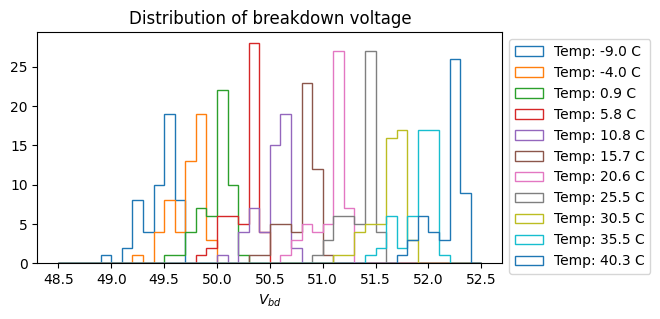

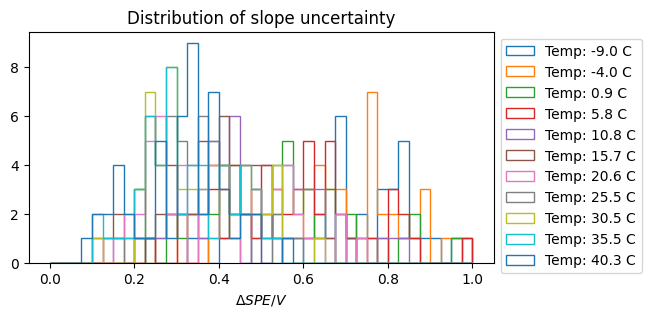

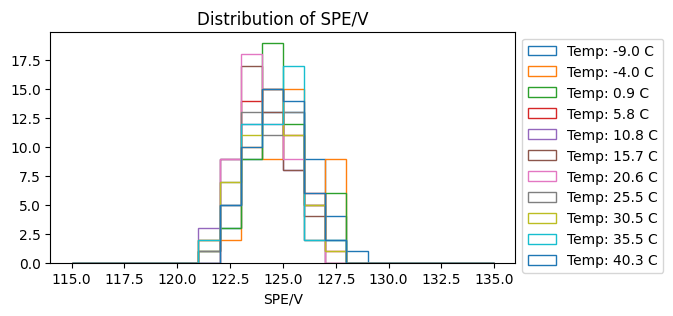

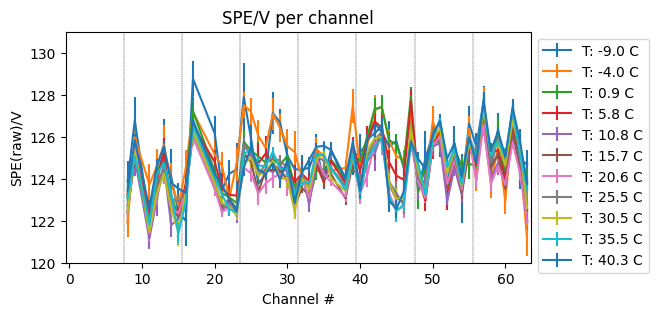

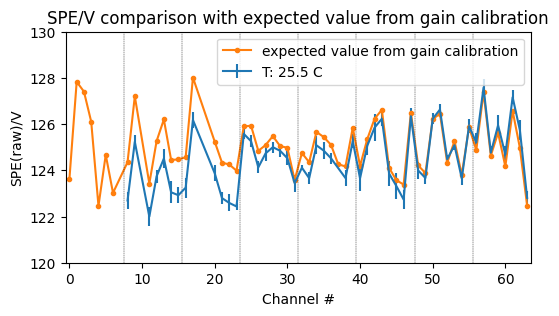

In [5]:
df_SPE_clean = df_SPE[~df_SPE['chan'].isin(bad_channels)]

plt.figure(figsize = (6,3))
for temp in tempSetups:
    df_ = df_SPE_clean.query('temp_setup == %f'%temp)
    plt.hist(df_['Vbd'], bins=40, range=(48.5, 52.5), histtype='step', 
             label='Temp: %.1f C'%np.mean(df_['tempCMB_mean']))
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.title('Distribution of breakdown voltage')
plt.xlabel('$V_{bd}$')
plt.show()
    
plt.figure(figsize = (6,3))
for temp in tempSetups:
    df_ = df_SPE_clean.query('temp_setup == %f'%temp)
    plt.hist(df_['SPEperV_err'], bins=40, range=(0, 1), histtype='step', 
             label='Temp: %.1f C'%np.mean(df_['tempCMB_mean']));
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.title('Distribution of slope uncertainty')
plt.xlabel('$\Delta SPE/V$')
plt.show()

plt.figure(figsize = (6,3))
for temp in tempSetups:
    df_ = df_SPE_clean.query('temp_setup == %f'%temp)
    plt.hist(df_['SPEperV'], bins=20, range=(115, 135), histtype='step', 
             label='Temp: %.1f C'%np.mean(df_['tempCMB_mean']));
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.title('Distribution of SPE/V')
plt.xlabel('SPE/V')
plt.show()

plt.figure(figsize = (6,3))
for temp in tempSetups:
    df_ = df_SPE_clean.query('temp_setup == %f'%temp)
    plt.errorbar(df_['chan'], df_['SPEperV'], yerr = df_['SPEperV_err'],
                 label='T: %.1f C'%np.mean(df_['tempCMB_mean']))
plt.title("SPE/V per channel")
plt.xlabel("Channel #")
plt.ylabel("SPE(raw)/V")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
for iAFE in range(8):
    plt.axvline(x=8*iAFE-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.3)
plt.gca().set_xlim(-0.5, 63+0.5)
plt.gca().set_ylim(120, 131)
plt.show()

chan1 = [0, 1, 2, 3, 4, 5, 6, 8, 9, 11, 12, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63]
SPEperVExpected = [123.62253886995464, 127.83310569156026, 127.40842200639085, 126.1057681125132, 122.45835110190967, 124.67055042408225, 123.02250125891544, 124.35069790962527, 127.20418845750999, 123.4277539149677, 125.26491272287947, 126.20142997127218, 124.44831173862676, 124.47308307150917, 124.56601441484167, 128.01729743349787, 125.24121486893159, 124.33190634136588, 124.25341125310337, 123.98448012833896, 125.9011930613668, 125.92983395065002, 124.84293361832556, 125.09385340544705, 125.47973843040765, 125.04893821120325, 124.97767679740849, 123.57977948760714, 124.74928437156055, 124.35070488816245, 125.66233648753675, 125.44231000001332, 125.10614240574756, 124.2628690619141, 124.16714763749167, 125.84475684425581, 124.18660519419953, 125.35479677644508, 126.23384469214321, 126.61607507136748, 124.10607533315314, 123.57219074549309, 123.38357309786662, 126.49178912055007, 124.21016714631617, 123.88241958432482, 126.21779666555719, 126.4493431097666, 124.32698563821333, 125.27018119343882, 123.80665215472297, 125.86901831771547, 124.88004425539583, 127.37808719735165, 124.63822370087743, 125.62311473677275, 124.16574780146976, 126.5750803395292, 124.97428671614142, 122.46931019118625]

plt.figure(figsize = (6,3))

df_ = df_SPE_clean.query('temp_setup == %f'%25)
plt.errorbar(df_['chan'], df_['SPEperV'], yerr = df_['SPEperV_err'],
             label='T: %.1f C'%np.mean(df_['tempCMB_mean']))
plt.plot(chan1, SPEperVExpected, '.-', label='expected value from gain calibration')
plt.title("SPE/V comparison with expected value from gain calibration")
plt.xlabel("Channel #")
plt.ylabel("SPE(raw)/V")
plt.legend()
for iAFE in range(8):
    plt.axvline(x=8*iAFE-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.3)
plt.gca().set_xlim(-0.5, 63+0.5)
plt.gca().set_ylim(120, 130)
plt.show()

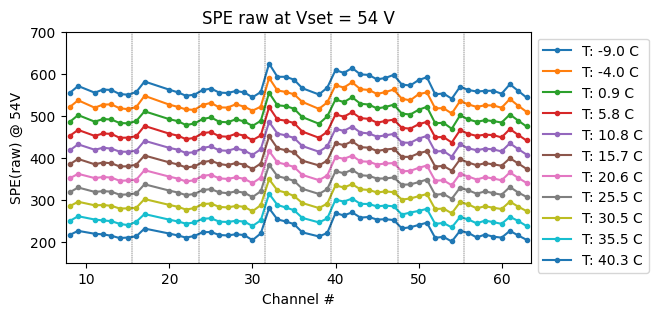

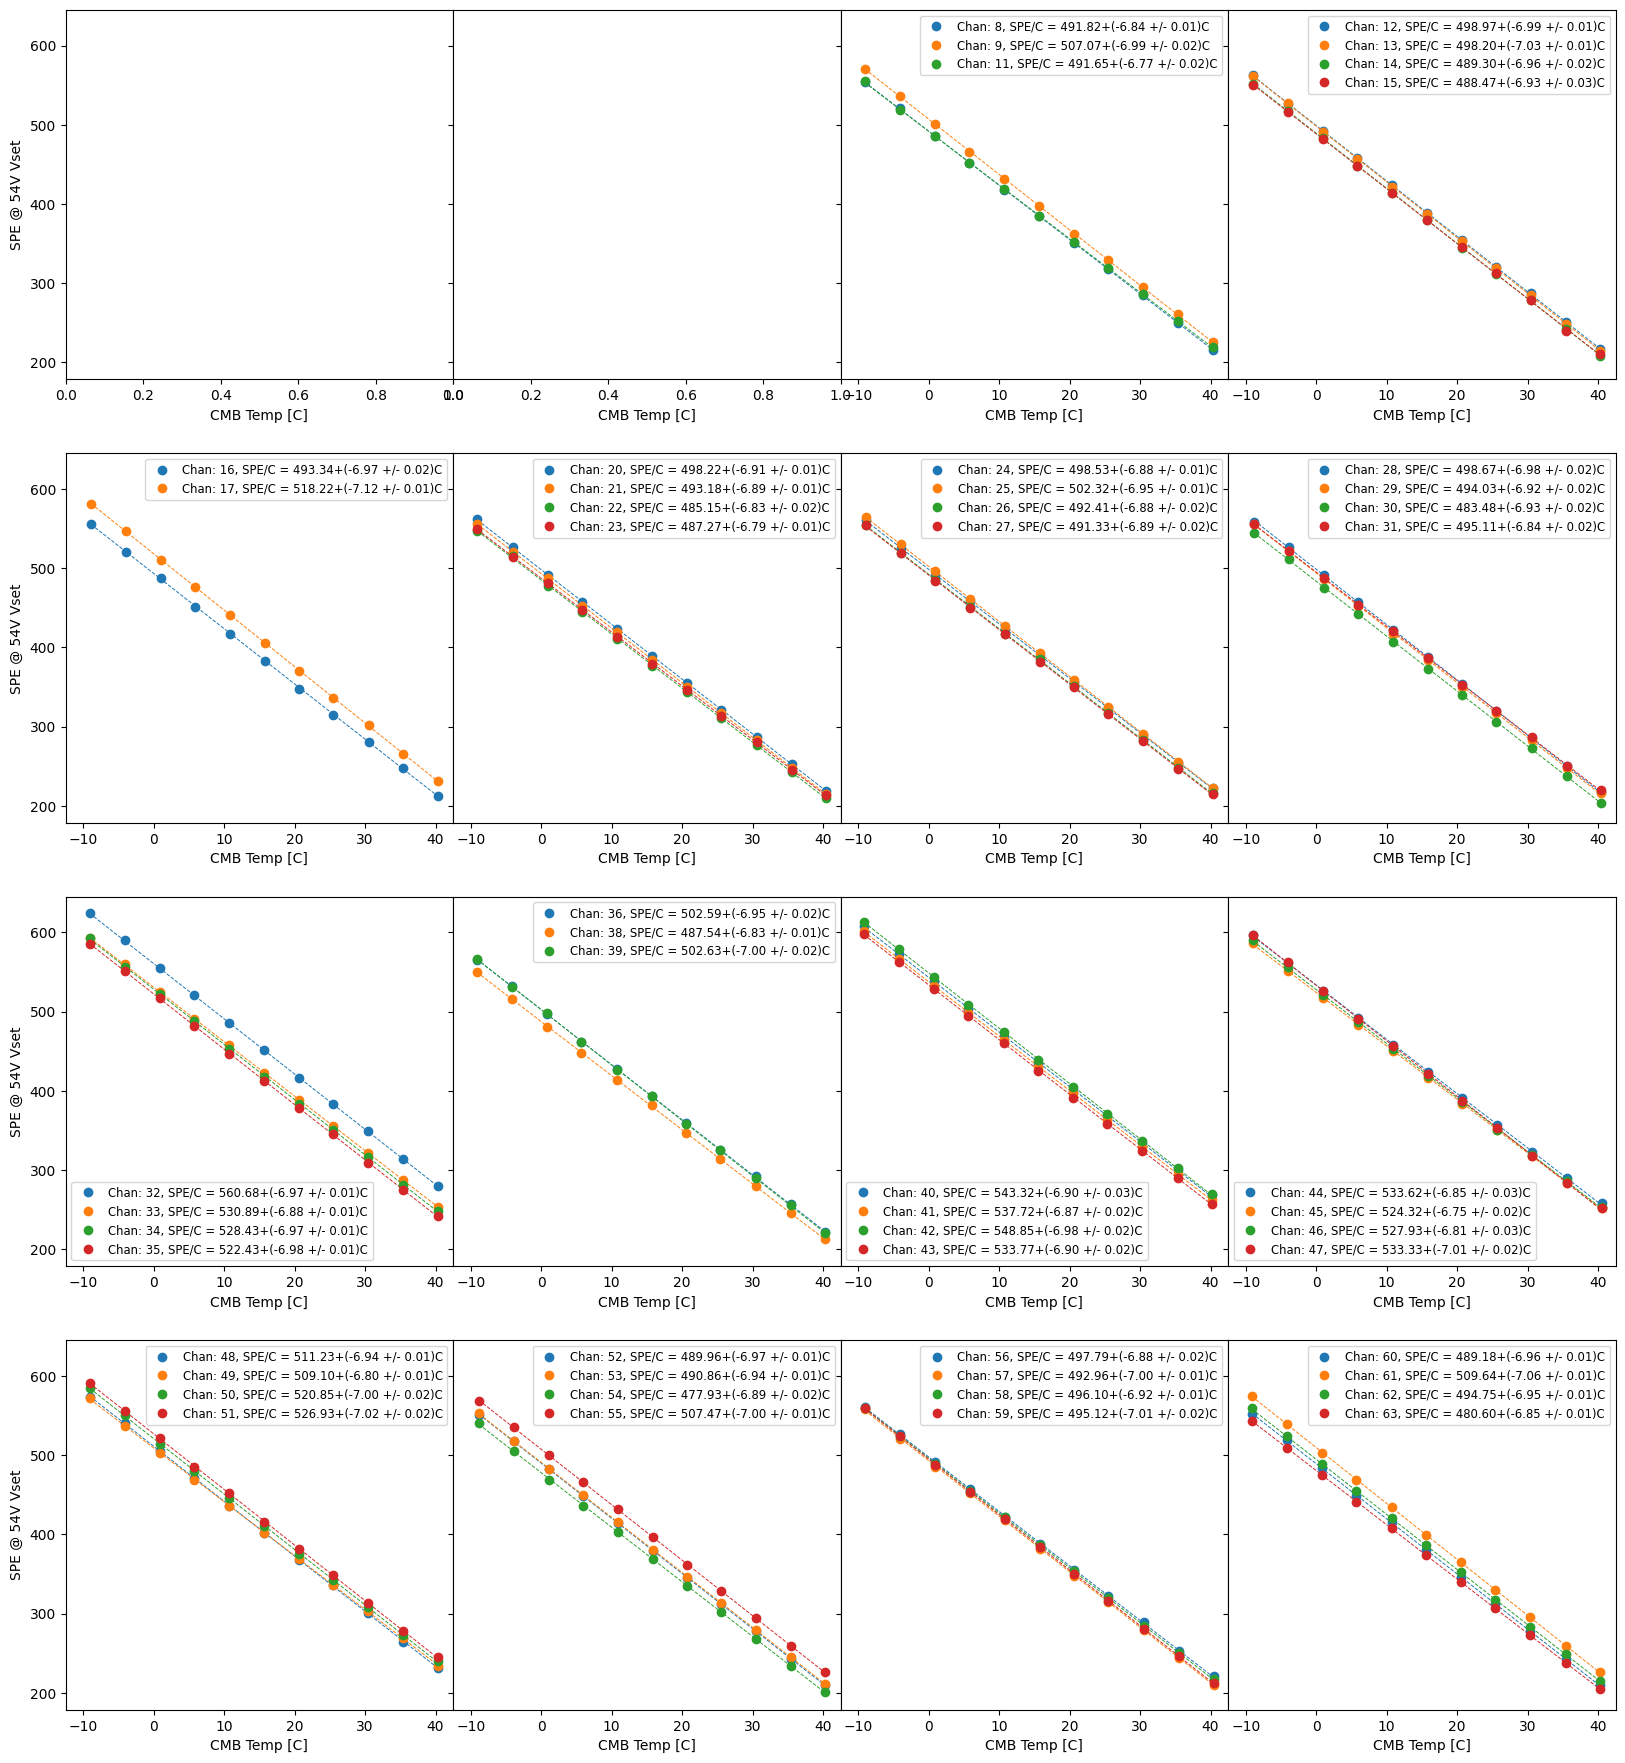

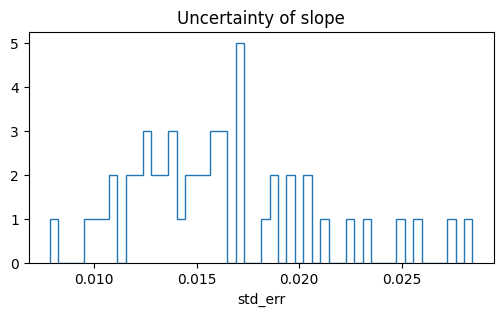

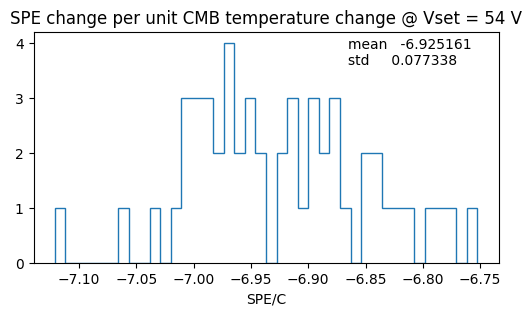

In [6]:
plt.figure(figsize = (6,3))
for temp in tempSetups:
    df_ = df_SPE_clean.query('temp_setup == %f'%temp)
    plt.plot(df_['chan'], df_['spe_54V_fix'],'.-',
                 label='T: %.1f C'%np.mean(df_['tempCMB_mean']))
plt.title("SPE raw at Vset = 54 V")
plt.xlabel("Channel #")
plt.ylabel("SPE(raw) @ 54V")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
for iAFE in range(1, 8):
    plt.axvline(x=8*iAFE-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.3)
plt.gca().set_xlim(7.5, 63+0.5)
plt.gca().set_ylim(150, 700)
plt.show()

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.96)

df_54V_Temp = pd.DataFrame(columns=['chan', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'])

for hdmi, ax in enumerate(axs.flatten()):
    ax.set_xlabel("CMB Temp [C]")
    if(hdmi%4 == 0):
        ax.set_ylabel("SPE @ 54V Vset")
    for inhdmi_chan in range(4):
        chan = hdmi*4+inhdmi_chan
        if chan in bad_channels or chan in range(8):
            continue
            
        x = df_SPE_clean.query('chan==%d'%chan)['tempCMB_mean'].astype(float)
        y = df_SPE_clean.query('chan==%d'%chan)['spe_54V_fix'].astype(float)

        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        markers = ax.plot(x, y, 'o', label='Chan: %d, SPE/C = %.2f+(%.2f +/- %.2f)C'%(chan, intercept, slope, std_err))
        ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
        ax.set_xlim(-12.5,42.5)
        ax.legend(fontsize='small')
        new_row = {'chan': chan, 'slope': slope, 'intercept': intercept,
                   'r_value': r_value, 'p_value': p_value, 'std_err': std_err}
        df_54V_Temp.loc[len(df_54V_Temp)] = new_row

plt.show()

plt.figure(figsize = (6,3))
plt.hist(df_54V_Temp['std_err'], histtype='step', bins=50)
plt.title('Uncertainty of slope')
plt.xlabel('std_err')
plt.show()

plt.figure(figsize = (6,3))
plt.hist(df_54V_Temp.query('std_err<0.3')['slope'], histtype='step', bins=40)
plt.title('SPE change per unit CMB temperature change @ Vset = 54 V')
plt.xlabel('SPE/C');
plt.figtext(0.65,0.77, df_54V_Temp['slope'].describe().loc[['mean','std']].to_string())
plt.show()

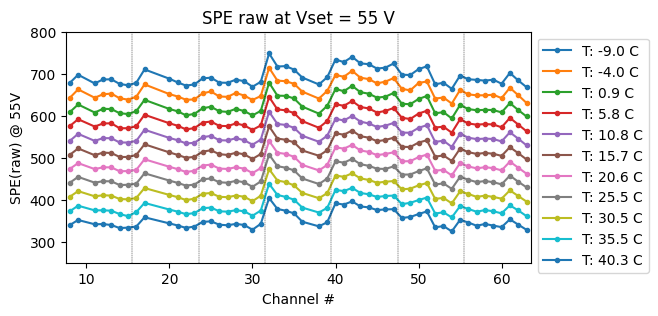

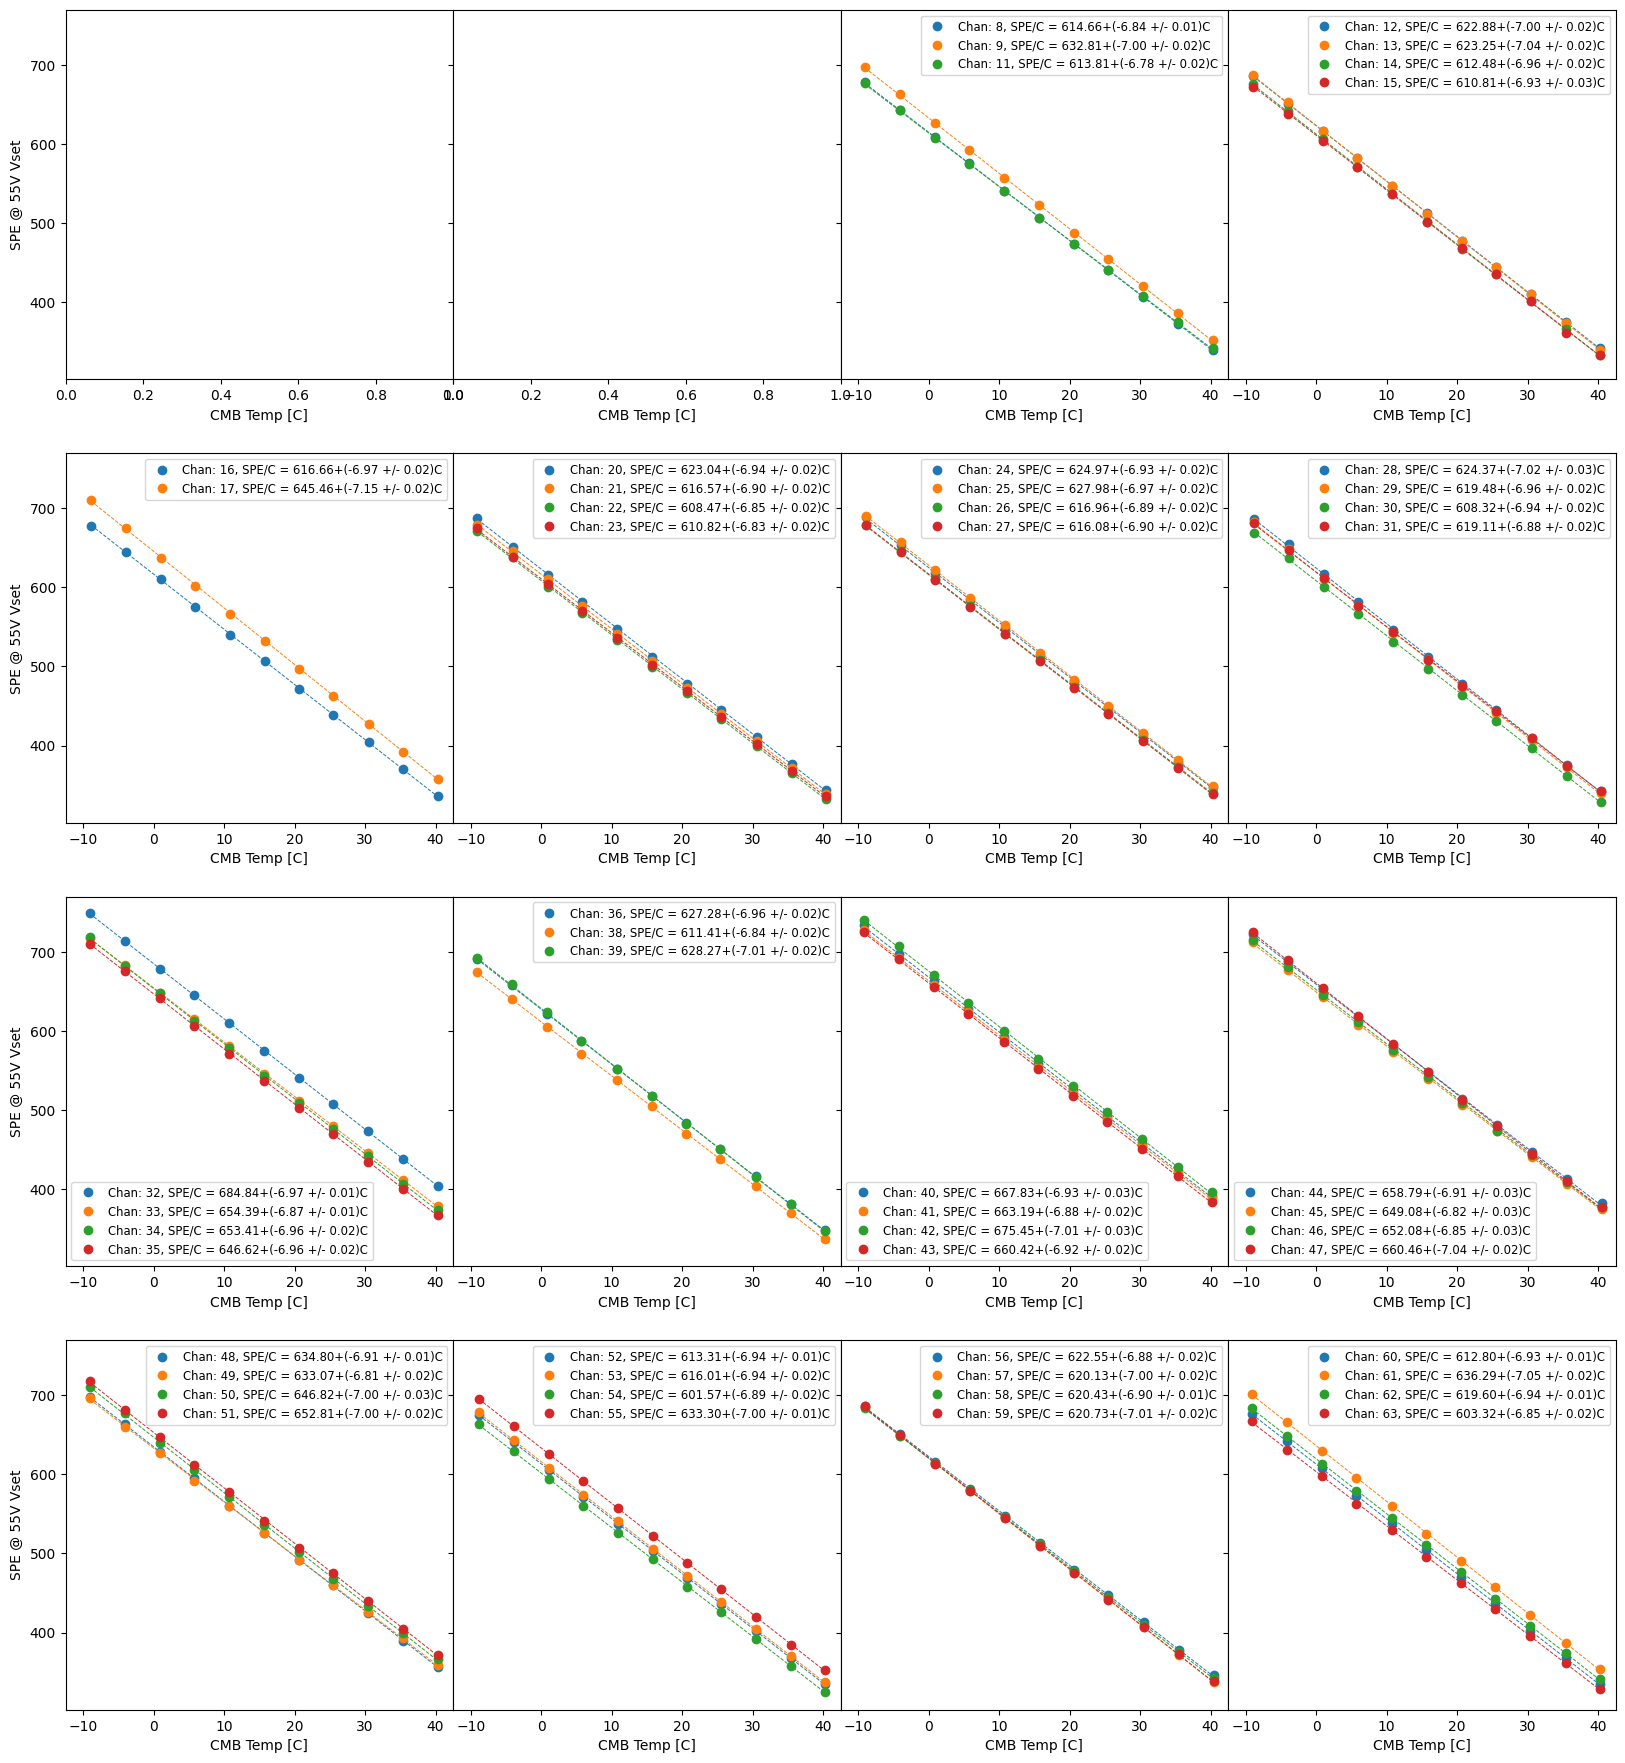

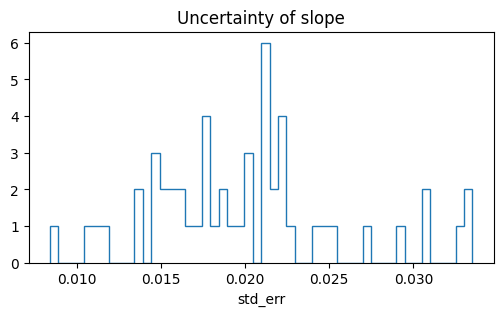

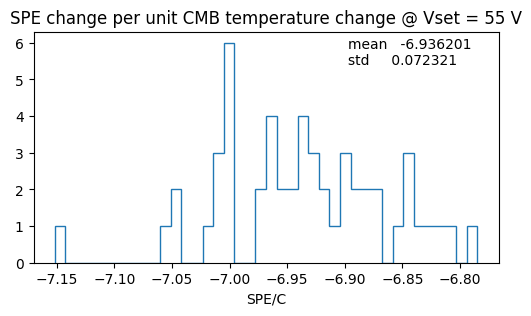

In [7]:
plt.figure(figsize = (6,3))
for temp in tempSetups:
    df_ = df_SPE_clean.query('temp_setup == %f'%temp)
    plt.plot(df_['chan'], df_['spe_55V_fix'],'.-',
                 label='T: %.1f C'%np.mean(df_['tempCMB_mean']))
plt.title("SPE raw at Vset = 55 V")
plt.xlabel("Channel #")
plt.ylabel("SPE(raw) @ 55V")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
for iAFE in range(1, 8):
    plt.axvline(x=8*iAFE-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.3)
plt.gca().set_xlim(7.5, 63+0.5)
plt.gca().set_ylim(250, 800)
plt.show()

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.96)

df_55V_Temp = pd.DataFrame(columns=['chan', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'])

for hdmi, ax in enumerate(axs.flatten()):
    ax.set_xlabel("CMB Temp [C]")
    if(hdmi%4 == 0):
        ax.set_ylabel("SPE @ 55V Vset")
    for inhdmi_chan in range(4):
        chan = hdmi*4+inhdmi_chan
        if chan in bad_channels or chan in range(8):
            continue
            
        x = df_SPE_clean.query('chan==%d'%chan)['tempCMB_mean'].astype(float)
        y = df_SPE_clean.query('chan==%d'%chan)['spe_55V_fix'].astype(float)

        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        markers = ax.plot(x, y, 'o', label='Chan: %d, SPE/C = %.2f+(%.2f +/- %.2f)C'%(chan, intercept, slope, std_err))
        ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
        ax.set_xlim(-12.5,42.5)
        ax.legend(fontsize='small')
        new_row = {'chan': chan, 'slope': slope, 'intercept': intercept,
                   'r_value': r_value, 'p_value': p_value, 'std_err': std_err}
        df_55V_Temp.loc[len(df_55V_Temp)] = new_row

plt.show()

plt.figure(figsize = (6,3))
plt.hist(df_55V_Temp['std_err'], histtype='step', bins=50)
plt.title('Uncertainty of slope')
plt.xlabel('std_err')
plt.show()

plt.figure(figsize = (6,3))
plt.hist(df_55V_Temp.query('std_err<0.3')['slope'], histtype='step', bins=40)
plt.title('SPE change per unit CMB temperature change @ Vset = 55 V')
plt.xlabel('SPE/C');
plt.figtext(0.65,0.77, df_55V_Temp['slope'].describe().loc[['mean','std']].to_string())
plt.show()

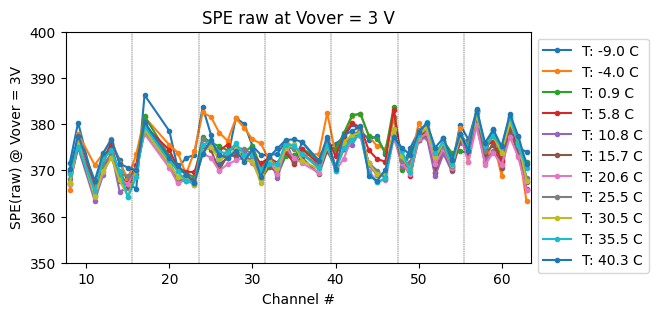

In [8]:
plt.figure(figsize = (6,3))
for temp in tempSetups:
    df_ = df_SPE_clean.query('temp_setup == %f'%temp)
    plt.plot(df_['chan'], df_['spe_3V_over'],'.-',
                 label='T: %.1f C'%np.mean(df_['tempCMB_mean']))
plt.title("SPE raw at Vover = 3 V")
plt.xlabel("Channel #")
plt.ylabel("SPE(raw) @ Vover = 3V")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
for iAFE in range(1, 8):
    plt.axvline(x=8*iAFE-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.3)
plt.gca().set_xlim(7.5, 63+0.5)
plt.gca().set_ylim(350, 400)
plt.show()

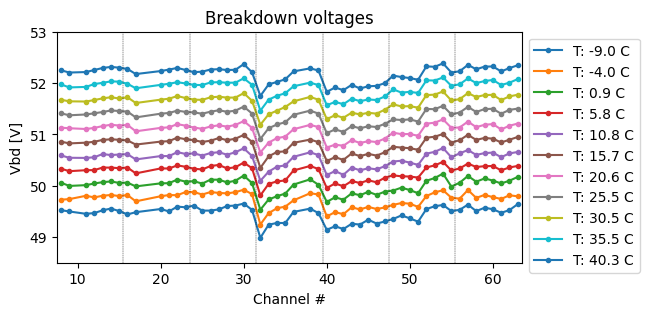

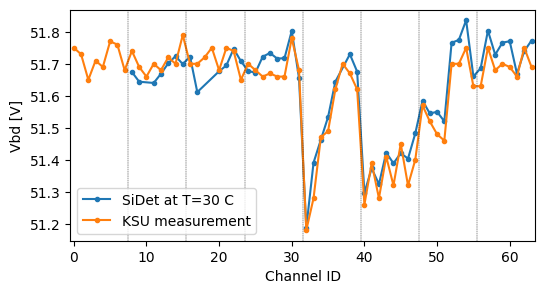

In [9]:
plt.figure(figsize = (6,3))
for temp in tempSetups:
    df_ = df_SPE_clean.query('temp_setup == %f'%temp)
    plt.plot(df_['chan'], df_['Vbd'],'.-',
                 label='T: %.1f C'%np.mean(df_['tempCMB_mean']))
plt.title("Breakdown voltages")
plt.xlabel("Channel #")
plt.ylabel("Vbd [V]")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
for iAFE in range(1, 8):
    plt.axvline(x=8*iAFE-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.3)
plt.gca().set_xlim(7.5, 63+0.5)
plt.gca().set_ylim(48.5, 53)
plt.show()

#Measurements from KSU
Vbd_txt = '''
    B4852		A31671	A31687	A31688	A31694	51.75	51.73	51.65	51.71
    B4922		A31723	A31714	A31719	A31716	51.69	51.77	51.76	51.68
    B4918		A31682	A31686	A31684	A31685	51.74	51.69	51.66	51.7
    B4920		A31724	A31725	A31721	A31715	51.68	51.72	51.7	51.79
    B3188		A14512	A14522	A14514	A14252	51.34	51.4	51.4	51.3
    B5087		A31679	A31666	A31676	A31678	51.72	51.69	51.66	51.65
    B4854		A31693	A31680	A31683	A31689	51.72	51.66	51.7	51.7
    B4919		A31681	A31722	A31712	A31720	51.75	51.69	51.71	51.66
    B1267		A14255	A14243	A14250	A14251	51.26	51.39	51.28	51.41
    B1287		A14526	A14523	A14516	A14524	51.32	51.45	51.32	51.4
    B1992		A15426	A15438	A15439	A15427	51.57	51.52	51.48	51.46
    B4924		A31677	A31675	A31673	A31668	51.7	51.7	51.75	51.63
    B5005		A31632	A31665	A31670	A31664	51.63	51.75	51.68	51.7
    B5088		A31672	A31674	A31667	A31669	51.69	51.66	51.75	51.69
    B4921		A31713	A31718	A31717	A31726	51.7	51.7	51.72	51.75
    B4853		A31690	A31691	A31695	A31692	51.68	51.75	51.74	51.65
    B4915		A31734	A31737	A31739	A31741	51.7	51.68	51.66	51.67
    B4983		A31738	A31740	A31731	A31735	51.66	51.66	51.78	51.68
    B1270		A14240	A14244	A15431	A15429	51.18	51.28	51.47	51.49
    B4923		A31728	A31729	A31743	A31736	51.62	51.7	51.67	51.62
    '''
Vbd_txt = Vbd_txt.strip().split('\n')
Vbd_dict = {}
for line in Vbd_txt:
    tID = line.split('\t')[0].lstrip()
    tVbd = [float(x) for x in line.split('\t')[6:]]
    Vbd_dict.update({tID:tVbd})
ID_list = ["B4852", "B4922", "B4918", "B4920",
           # "B1267", "B1287", "B1992", "B4924", "B5005", "B5088",
           "B4921", "B4853", "B4915", "B4983", "B1270", "B4923",
           "B1267", "B1287", "B1992", "B4924", "B5005", "B5088"]
ch = [i for i in range(64)]
Vbd = []
for ID in ID_list:
    Vbd += Vbd_dict[ID]

#Compare KSU and SiDet
temp_KSU=30
df_ = df_SPE_clean.query('temp_setup == %f'%temp_KSU)
plt.figure(figsize = (6,3))
plt.plot(df_['chan'], df_['Vbd'], '.-', label=('SiDet at T=%d C'%np.mean(df_['tempCMB_mean'])))
plt.plot(Vbd, '.-', label='KSU measurement');
plt.xlabel('Channel ID')
plt.ylabel('Vbd [V]')
plt.legend()
for iAFE in range(0, 8):
    plt.axvline(x=8*iAFE-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.3)
plt.gca().set_xlim(-0.5, 63+0.5)
plt.show()


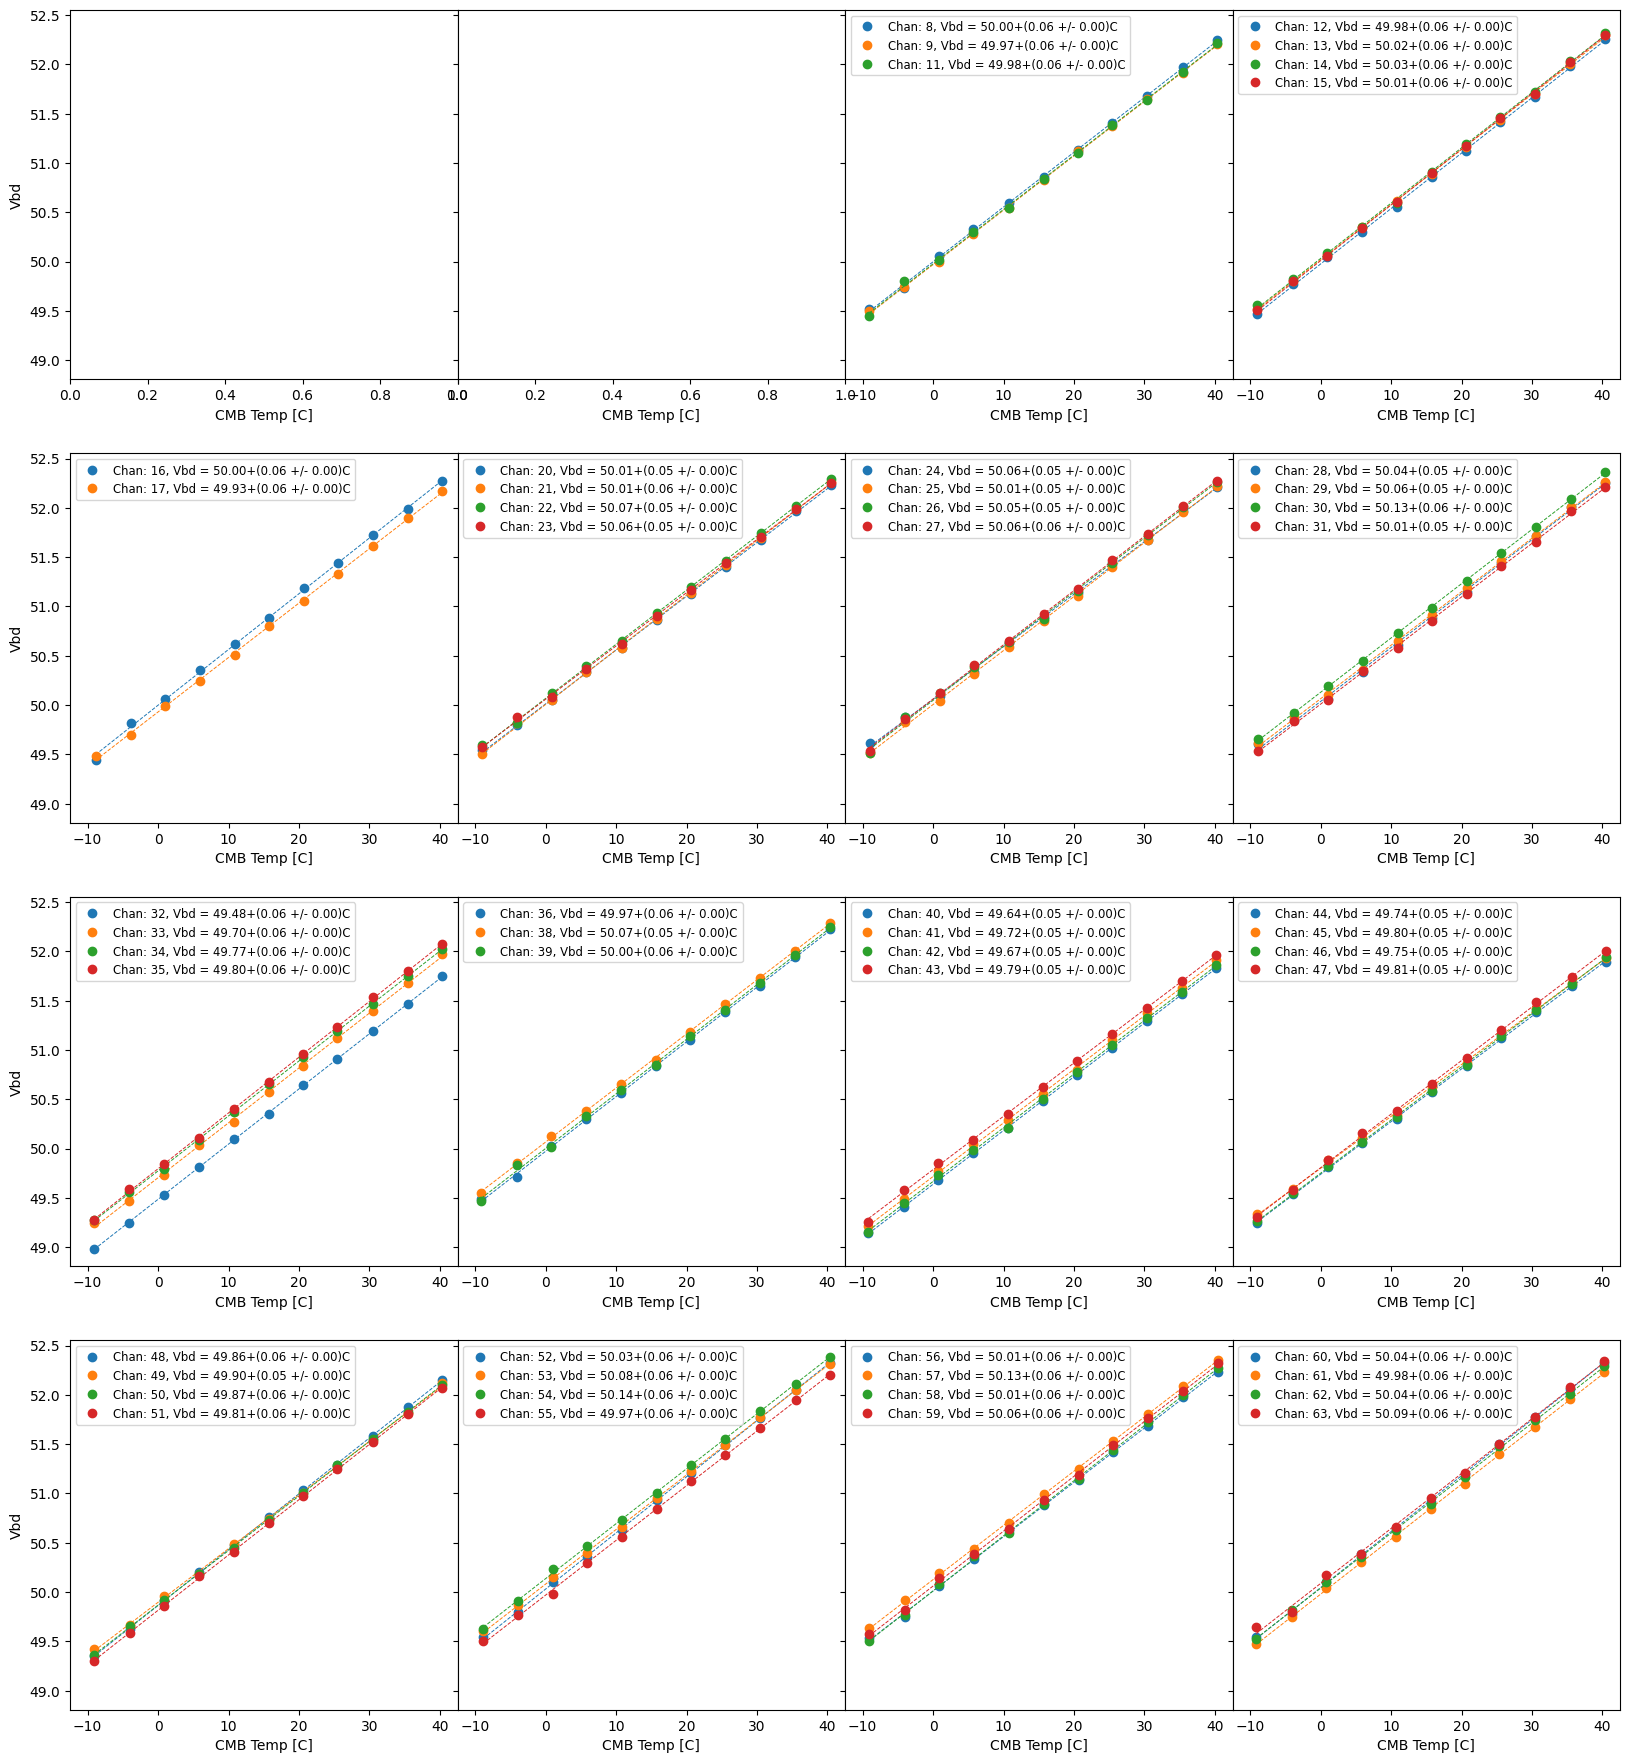

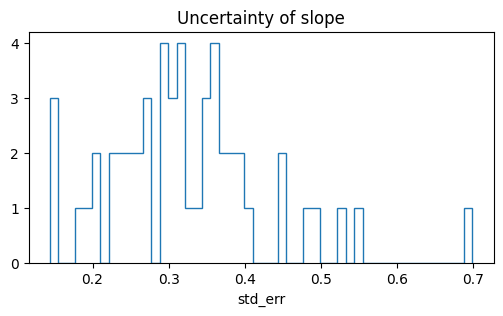

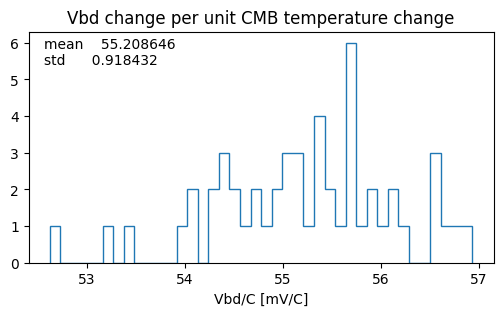

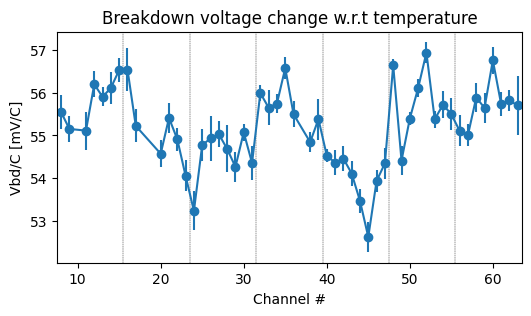

In [10]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(20, 20), sharey=True)
plt.subplots_adjust(wspace=0)
fig.subplots_adjust(top=0.96)

df_Vbd = pd.DataFrame(columns=['chan', 'slope', 'intercept', 'r_value', 'p_value', 'std_err'])

for hdmi, ax in enumerate(axs.flatten()):
    ax.set_xlabel("CMB Temp [C]")
    if(hdmi%4 == 0):
        ax.set_ylabel("Vbd")
    for inhdmi_chan in range(4):
        chan = hdmi*4+inhdmi_chan
        if chan in bad_channels or chan in range(8):
            continue
            
        x = df_SPE_clean.query('chan==%d'%chan)['tempCMB_mean'].astype(float)
        y = df_SPE_clean.query('chan==%d'%chan)['Vbd'].astype(float)

        slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
        markers = ax.plot(x, y, 'o', label='Chan: %d, Vbd = %.2f+(%.2f +/- %.2f)C'%(chan, intercept, slope, std_err))
        ax.plot(x, slope * x + intercept, '--', color = markers[0].get_color(), linewidth=0.7)
        ax.set_xlim(-12.5,42.5)
        ax.legend(fontsize='small')
        new_row = {'chan': chan, 'slope': slope*1000, 'intercept': intercept,
                   'r_value': r_value, 'p_value': p_value, 'std_err': std_err*1000}
        df_Vbd.loc[len(df_Vbd)] = new_row

plt.show()

plt.figure(figsize = (6,3))
plt.hist(df_Vbd['std_err'], histtype='step', bins=50)
plt.title('Uncertainty of slope')
plt.xlabel('std_err')
plt.show()

plt.figure(figsize = (6,3))
plt.hist(df_Vbd.query('std_err<5')['slope'], histtype='step', bins=40)
plt.title('Vbd change per unit CMB temperature change')
plt.xlabel('Vbd/C [mV/C]');
plt.figtext(0.15,0.77, df_Vbd['slope'].describe().loc[['mean','std']].to_string())
plt.show()

plt.figure(figsize = (6,3))
plt.errorbar(df_Vbd['chan'], df_Vbd['slope'], yerr = df_Vbd['std_err'], marker='o')
plt.title("Breakdown voltage change w.r.t temperature")
plt.xlabel("Channel #")
plt.ylabel("Vbd/C [mV/C]")
for iAFE in range(1, 8):
    plt.axvline(x=8*iAFE-0.5, color='k', linestyle='-'if iAFE==0 else '--', linewidth=0.3)
plt.gca().set_xlim(7.5, 63+0.5)
plt.show()

In [11]:
#save dfs
pklname = os.path.join(analysis_dir,"tempScanSiDetRun2SPE.pkl")
with open(pklname, 'wb') as f:
    pickle.dump(df_SPE_clean, f)
    pickle.dump(df_54V_Temp, f)
    pickle.dump(df_55V_Temp, f)
    pickle.dump(df_Vbd, f)    